# Fundamentals of Machine Learning - Exercise 2
Submission by Dominique Cheray

In [1]:
from sklearn.datasets import load_digits
from sklearn import model_selection
import numpy as np
import matplotlib.pyplot as plt
from scipy import spatial
import math
import matplotlib.mlab as mlab
from sklearn.model_selection import KFold

## 1 Data Preparation

In [2]:
digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# filter the data for 1 and 7
filter_mask = (target == 1) | (target == 7)
data = data[filter_mask]
images = images[filter_mask]
target = target[filter_mask]

print(target.shape)

# split data into test and trainig set 
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(data, target, 
                                                                    test_size =0.33, random_state=0)

print(X_train.shape, X_test.shape)

dict_keys(['target_names', 'images', 'data', 'target', 'DESCR'])
(361,)
(241, 64) (120, 64)


### 1.1 Dimension Reduction

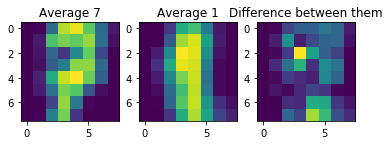

[19 60]
(241, 2) (120, 2)


In [3]:
# get the ones and sevens
ones = images[target==1]
sevens = images[target==7]

# get average image for ones and sevens
sevens_average = np.mean(sevens, axis=0)
ones_average = np.mean(ones, axis=0)
# get absolute differences of sevens and ones
difference = np.abs(np.subtract(sevens_average, ones_average))
# plot the images
fig = plt.figure()
fig.add_subplot(1, 3, 1)
plt.title('Average 7')
plt.imshow(sevens_average)
fig.add_subplot(1, 3, 2)
plt.title('Average 1')
plt.imshow(ones_average)
fig.add_subplot(1, 3, 3)
plt.title('Difference between them')
plt.imshow(difference)
plt.show()
# reshape the differences array and then get indices of 2 biggest
# values to use them for the feature extraction
difference_flat = np.reshape(difference, (64))
indices = difference_flat.argsort()[-2:][::-1]
print(indices)


def reduce_dim(x):
    return x[:, [19, 60]]

X_train_reduced = reduce_dim(X_train)
X_test_reduced = reduce_dim(X_test)
print(X_train_reduced.shape, X_test_reduced.shape)

### 1.2 Scatterplot

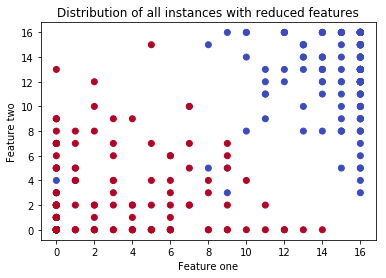

In [4]:
data_reduced = reduce_dim(data)
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=target, cmap=plt.cm.coolwarm)
plt.xlabel('Feature one')
plt.ylabel('Feature two')
plt.title('Distribution of all instances with reduced features')
plt.show()

## 2 Nearest Mean
### 2.1 Implement the nearest mean classifier

In [5]:
def nearest_mean(training_features, training_labels, test_features):
    # get the labels of the training data
    unique_labels = np.unique(training_labels)
    means = []
    # calculate means of features for training data
    for i in range(len(unique_labels)):
        cl = training_features[training_labels == unique_labels[i]]
        means.append(np.mean(cl, axis=0))
    # calculate distance of test_features to mean of each class
    distances = spatial.distance_matrix(test_features, means)
    # get the smaller distance
    minimal_distances = np.argmin(distances, axis=1)
    return unique_labels[minimal_distances]


predicted_labels = nearest_mean(X_train_reduced, Y_train, X_test_reduced)

print('Classifier error: '+ 
      str((np.count_nonzero((predicted_labels - Y_test))/len(predicted_labels))*100)
     + '%')

Classifier error: 0.8333333333333334%


### 2.2 Visualize the decision regions

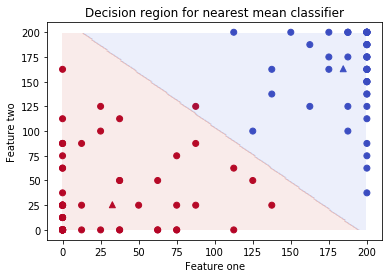

In [6]:
# rescale the features (min_features = 0, max_features = 16)
X_test_rescaled = X_test_reduced[:,:] * 200 / 16
X_train_rescaled = X_train_reduced[:,:] * 200 / 16
# create a grid of 200x200 anf plot decision regions
xx, yy = np.meshgrid(np.arange(0, 200, 1),
                     np.arange(0, 200, 1))
z = nearest_mean(X_train_rescaled, Y_train, np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

# get the means for plotting
unique_labels = np.unique(Y_train)
means = []
for i in range(len(unique_labels)):
    cl = X_train_reduced[Y_train == unique_labels[i]]
    means.append(np.mean(cl, axis=0))
means = np.asarray(means)
means = means[:,:] * 200 /16
unique_labels = np.asarray(unique_labels)

plt.scatter(X_test_rescaled[:, 0], X_test_rescaled[:, 1], c=Y_test, alpha=1, cmap=plt.cm.coolwarm)
plt.scatter(means[:, 0], means[:, 1], c=unique_labels, marker="^", alpha=1.5, cmap=plt.cm.coolwarm)
plt.contourf(xx, yy, z, alpha=0.1, cmap=plt.cm.coolwarm)
plt.xlabel('Feature one')
plt.ylabel('Feature two')
plt.title('Decision region for nearest mean classifier')
plt.show()

## 3 QDA
### 3.1 Implement QDA Training

In [7]:
def fit_qda(training_features, training_labels):
    # get the labels of the classes
    unique_labels = np.unique(training_labels)
    mean = []
    covmat = []
    prior = []

    for label in unique_labels:
        # get all instances of one class
        cl = training_features[training_labels == label]
        # calculate mean for class
        mean.append(np.mean(cl, axis=0))
        # calculate covariance matrix for class
        covmat.append(np.cov(cl.T))
        # calculate prior for class
        prior.append(len(cl)/len(training_features))
    
    mean = np.asarray(mean)
    covmat = np.asarray(covmat)
    prior = np.asarray(prior)
    return mean, covmat, prior

mu, covmat, p = fit_qda(X_train_reduced, Y_train)

### 3.2 Implement QDA Prediction

In [8]:
def predict_qda(mu, covmat, p, test_features):
    all_predictions = [] 

    for i in range(len(mu[0])):
        prediction_i = []
        b = math.log(np.linalg.det(covmat[i])) - math.log(p[i])
        for feature in test_features:
            x_centered = feature - mu[i]
            prediction_i.append((((0.5*x_centered).dot(np.linalg.inv(covmat[i]))).dot(x_centered.T))+b)
        all_predictions.append(prediction_i)

    all_predictions = np.asarray(all_predictions)
    return np.argmin(all_predictions, axis=0)


qda_predicted_train = predict_qda(mu, covmat, p, X_train_reduced)
qda_predicted_train[qda_predicted_train == 1] = 7
qda_predicted_train[qda_predicted_train == 0] = 1

print('Training error: '+ 
      str((np.count_nonzero((qda_predicted_train - Y_train))/len(qda_predicted_train))*100)
     + '%')

qda_predicted_test = predict_qda(mu, covmat, p, X_test_reduced)
qda_predicted_test[qda_predicted_test == 1] = 7
qda_predicted_test[qda_predicted_test == 0] = 1

print('Test error: '+ 
      str((np.count_nonzero((qda_predicted_test - Y_test))/len(qda_predicted_test))*100)
     + '%')


Training error: 2.4896265560165975%
Test error: 0.0%


### 3.3 Visualization

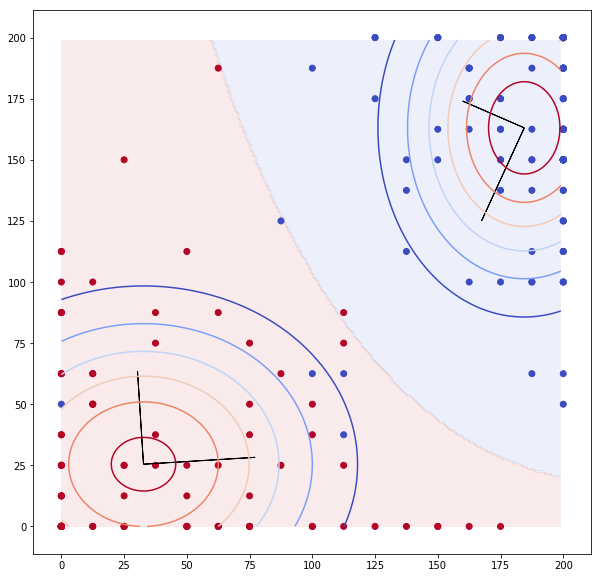

In [9]:
# train the qda on the image space
mu, covmat, p = fit_qda(X_train_rescaled, Y_train)
# create a grid to plot the decision regions
xx, yy = np.meshgrid(np.arange(0, 200, 1),
                     np.arange(0, 200, 1))
z = predict_qda(mu, covmat, p, np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)
#Create Gaussians for plotting              
Z1 = mlab.bivariate_normal(xx, yy,np.sqrt(covmat[0][0][0]), np.sqrt(covmat[0][1][1]), mu[0][0], mu[0][1])
Z2 = mlab.bivariate_normal(xx, yy,np.sqrt(covmat[1][0][0]), np.sqrt(covmat[1][1][1]), mu[1][0], mu[1][1])

eigenvals1, eigenvecs1 = np.linalg.eig(covmat[0])
eigenvals2, eigenvecs2 = np.linalg.eig(covmat[1])
eigenvals1 = np.sqrt(eigenvals1)
eigenvals2 = np.sqrt(eigenvals2)

axis1 = eigenvecs1[:, 1] * eigenvals1[1]
axis2 = eigenvecs1[:, 0] * eigenvals1[0]
axis3 = eigenvecs2[:, 0] * eigenvals2[0]
axis4 = eigenvecs2[:, 1] * eigenvals2[1]

plt.figure(figsize=(10,10))
ax = plt.axes()
plt.contourf(xx, yy, z, alpha=0.1, cmap=plt.cm.coolwarm)
plt.scatter(X_train_rescaled[:,0], X_train_rescaled[:,1], c=Y_train, alpha=1, cmap=plt.cm.coolwarm)
plt.contour(xx, yy, Z1, cmap=plt.cm.coolwarm)
plt.contour(xx, yy, Z2, cmap=plt.cm.coolwarm)
ax.arrow(mu[0][0], mu[0][1], axis1[0], axis1[1])
ax.arrow(mu[0][0], mu[0][1], axis2[0], axis2[1])
ax.arrow(mu[1][0], mu[1][1], axis3[0], axis3[1])
ax.arrow(mu[1][0], mu[1][1], axis4[0], axis4[1])
plt.show()

### 3.4 Performance evaluation

In [10]:
n_folds = 10
kf = KFold(n_splits=n_folds)
meanerror = 0
for train, test in kf.split(target):
    X_train_CV, X_test_CV, Y_train_CV, Y_test_CV = data_reduced[train], data_reduced[test], target[train], target[test]
    mu, covmat, p = fit_qda(X_train_CV, Y_train_CV)
    predicted_labels = predict_qda(mu, covmat, p, X_test_CV)
    predicted_labels[predicted_labels == 1] = 7
    predicted_labels[predicted_labels == 0] = 1
    meanerror = meanerror + (np.count_nonzero(predicted_labels - Y_test_CV) / len(predicted_labels))

meanerror = meanerror / n_folds
print('Cross validation test error: ' + str(meanerror*100) +'%' )

Cross validation test error: 1.9369369369369374%


## 4 LDA
### 4.1 Implement LDA Training

In [11]:
def fit_lda(training_features, training_labels):
    # get the class labels
    unique_labels = np.unique(training_labels)
    means = []
    covmat = np.zeros((len(training_features[0]), len(training_features[0])))
    prior = []

    for label in unique_labels:
        # get all instances of class
        cl = training_features[training_labels == label]
        # calculate mean for class
        mean = np.mean(cl, axis=0)
        means.append(mean)
        # calculate prior for class
        prior.append(len(cl)/len(training_features))
        # calculate the covariance matrix for the class 
        # and weight it by size of its class
        covmat = covmat + (np.cov(cl.T) * (len(cl) - 1))
    means = np.asarray(means)
    prior = np.asarray(prior)
    # divide covmat by (N-K)
    covmat = covmat[:, :] / (len(training_features) - len(unique_labels))
                            
    return means, covmat, prior

mu, covmat, p = fit_lda(X_train_reduced, Y_train)

### 4.2 Implement LDA Prediction

In [12]:

def predict_lda(mu, covmat, p, test_features):
    all_predictions = []
    covmat_inv = np.linalg.inv(covmat)
    for i in range(len(mu[0])):
        prediction_i = []
        # for every class calculate b
        b = math.log((np.linalg.det(covmat))) - math.log(p[i])
        # for every feature calculate the prediction
        for feature in test_features: 
            prediction_i.append((2*mu[i]).T.dot(covmat_inv).dot(feature) - mu[i].T.dot(covmat_inv).dot(mu[i]) - b)
        all_predictions.append(prediction_i)

    all_predictions = np.asarray(all_predictions)
    # return the class maximizing the prediction
    return np.argmax(all_predictions, axis=0)


lda_predicted_train = predict_lda(mu, covmat, p, X_train_reduced)
lda_predicted_train[lda_predicted_train == 1] = 7
lda_predicted_train[lda_predicted_train == 0] = 1
print('Training error: '+ 
      str((np.count_nonzero((lda_predicted_train - Y_train))/len(lda_predicted_train))*100)
     + '%')

lda_predicted_test = predict_lda(mu, covmat, p, X_test_reduced)
lda_predicted_test[lda_predicted_test == 1] = 7
lda_predicted_test[lda_predicted_test == 0] = 1
print('Test error: '+ 
      str((np.count_nonzero((lda_predicted_test - Y_test))/len(lda_predicted_test))*100)
     + '%')

Training error: 2.0746887966804977%
Test error: 0.8333333333333334%


### 4.3 Visualization

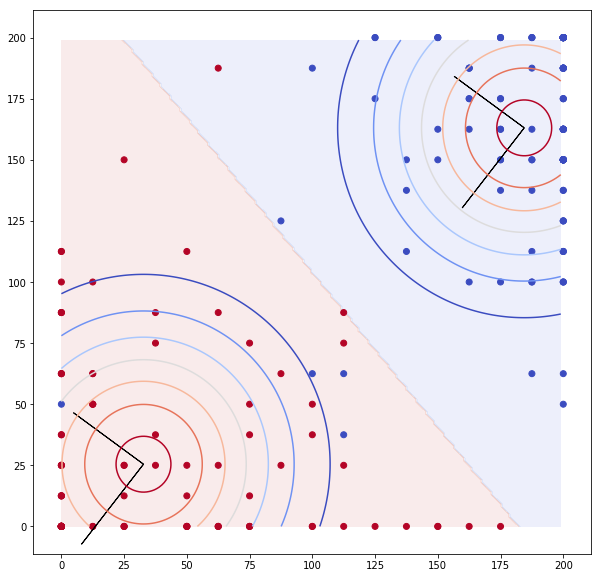

In [13]:
# train the LDA on the image space
mu, covmat, p = fit_lda(X_train_rescaled, Y_train)
# create a grid of 200x200 to plot decision regions
xx, yy = np.meshgrid(np.arange(0, 200, 1),
                     np.arange(0, 200, 1))
z = predict_lda(mu, covmat, p, np.c_[xx.ravel(), yy.ravel()])
z = z.reshape(xx.shape)

Z1 = mlab.bivariate_normal(xx, yy, np.sqrt(covmat[0][0]), np.sqrt(covmat[1][1]), mu[0][0], mu[0][1])
Z2 = mlab.bivariate_normal(xx, yy, np.sqrt(covmat[0][0]), np.sqrt(covmat[1][1]), mu[1][0], mu[1][1])

eigenvals, eigenvecs = np.linalg.eig(covmat)
eigenvals = np.sqrt(eigenvals)

axis1 = eigenvecs[:, 0] * eigenvals[0]
axis2 = eigenvecs[:, 1] * eigenvals[1]

plt.figure(figsize=(10,10))
ax = plt.axes()
plt.contourf(xx, yy, z, alpha=0.1, cmap=plt.cm.coolwarm)
plt.scatter(X_train_rescaled[:,0], X_train_rescaled[:,1], c=Y_train, alpha=1, cmap=plt.cm.coolwarm)
plt.contour(xx, yy, Z1, cmap=plt.cm.coolwarm)
plt.contour(xx, yy, Z2, cmap=plt.cm.coolwarm)
ax.arrow(mu[0][0], mu[0][1], axis1[0], axis1[1])
ax.arrow(mu[0][0], mu[0][1], axis2[0], axis2[1])
ax.arrow(mu[1][0], mu[1][1], axis1[0], axis1[1])
ax.arrow(mu[1][0], mu[1][1], axis2[0], axis2[1])
plt.show()

### 4.4 Performance evaluation

In [14]:
n_folds = 10
kf = KFold(n_splits=n_folds)
meanerror = 0
for train, test in kf.split(target):
    X_train_CV, X_test_CV, Y_train_CV, Y_test_CV = data_reduced[train], data_reduced[test], target[train], target[test]
    mu, covmat, p = fit_lda(X_train_CV, Y_train_CV)
    predicted_labels = predict_lda(mu, covmat, p, X_test_CV)
    predicted_labels[predicted_labels == 1] = 7
    predicted_labels[predicted_labels == 0] = 1
    meanerror = meanerror + (np.count_nonzero(predicted_labels - Y_test_CV) / len(predicted_labels))

meanerror = meanerror / n_folds
print('Cross validation test error: ' + str(meanerror*100) +'%' )

Cross validation test error: 2.4924924924924925%
